<a href="https://colab.research.google.com/github/bboszori/data_science_tasks/blob/main/classification_3_homework_bboszori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification homework

## Saving data from Kaggle

In [ ]:
! pip install kaggle --quiet

In [ ]:
! mkdir '/content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data'

In [ ]:
! kaggle competitions download -c epamdscourseclassification32022

 40% 5.00M/12.4M [00:00<00:00, 29.4MB/s]
100% 12.4M/12.4M [00:00<00:00, 60.2MB/s]


In [ ]:
! unzip {"epamdscourseclassification32022" + ".zip"} -d '/content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data'

Archive:  epamdscourseclassification32022.zip
  inflating: /content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data/id_map.parquet  
  inflating: /content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data/test.csv  
  inflating: /content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data/train.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls '/content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data'

id_map.parquet	mapping.csv  test.csv  train.csv


## Importing libraries

In [ ]:
!pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import re
import string
import tldextract

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import hyperopt
from hyperopt import hp, tpe, fmin, STATUS_OK

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer

from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Loading data

In [ ]:
# Commonly used constants and paths
SEED = 42
DATA_PATH = '/content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/kaggle_data'
TRAIN_FILE = f'{DATA_PATH}/train.csv'
TEST_FILE = f'{DATA_PATH}/test.csv'
ID_MAP = f'{DATA_PATH}/id_map.parquet'
TARGET = 'target'

In [ ]:
train_data = pd.read_csv(TRAIN_FILE)
train_data.head()

,session_id,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,...,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
0,0,9486,2019-02-20 05:57:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,...,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,...,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,...,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,...,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


In [ ]:
test_data = pd.read_csv(TEST_FILE)
test_data.head()

,session_id,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,...,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10
0,0,10318,2019-03-28 06:47:12,10318.0,2019-03-28 06:47:42,10318.0,2019-03-28 06:48:12,10318.0,2019-03-28 06:48:42,10318.0,...,10318.0,2019-03-28 06:49:42,10318.0,2019-03-28 06:50:12,10318.0,2019-03-28 06:50:42,10318.0,2019-03-28 06:51:12,10318.0,2019-03-28 06:51:42
1,1,438,2019-02-28 06:48:05,2453.0,2019-02-28 06:50:22,2427.0,2019-02-28 06:50:22,2466.0,2019-02-28 06:50:23,2453.0,...,2466.0,2019-02-28 06:50:59,2427.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:52:06,2466.0,2019-02-28 06:52:11
2,2,7562,2019-03-18 11:13:31,425.0,2019-03-18 11:13:39,7562.0,2019-03-18 11:18:02,425.0,2019-03-18 11:18:43,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,8836,2019-03-17 12:18:08,12372.0,2019-03-17 12:18:35,12398.0,2019-03-17 12:18:35,12385.0,2019-03-17 12:18:35,12385.0,...,12398.0,2019-03-17 12:18:36,12372.0,2019-03-17 12:18:36,451.0,2019-03-17 12:18:52,425.0,2019-03-17 12:18:52,438.0,2019-03-17 12:18:53
4,4,451,2019-03-31 09:46:43,9863.0,2019-03-31 09:46:44,451.0,2019-03-31 09:46:46,9889.0,2019-03-31 09:46:46,451.0,...,425.0,2019-03-31 09:47:46,9928.0,2019-03-31 09:49:43,867.0,2019-03-31 10:05:12,880.0,2019-03-31 10:05:12,867.0,2019-03-31 10:05:13


In [ ]:
id_map = pd.read_parquet(ID_MAP)

In [ ]:
id_map['webpage'].nunique()

48371

In [ ]:
def extractDomain(url):
  '''
    PArsing only the domain + top-level-domain from the webpage data
  '''
  ext = tldextract.extract(url)
  if ext.suffix=='':
    return ext.domain
  else:
    return ext.domain + '.' + ext.suffix

#Removing 'www' from the webpages
id_map['webpage_proc'] = id_map['webpage'].apply(lambda x: re.sub("^\S*?\.*?www\S*?\.", '', x))
id_map['domain_only'] = id_map['webpage_proc'].apply(lambda x: extractDomain(x))

In [ ]:
id_map.head()

,id,webpage,webpage_proc,domain_only
0,326127,www.abmecatronique.com,abmecatronique.com,abmecatronique.com
1,182113,groups.live.com,groups.live.com,live.com
2,551820,majeureliguefootball.wordpress.com,majeureliguefootball.wordpress.com,wordpress.com
3,401995,cdt46.media.tourinsoft.eu,cdt46.media.tourinsoft.eu,tourinsoft.eu
4,105504,www.hdwallpapers.eu,hdwallpapers.eu,hdwallpapers.eu


## EDA

<Figure size 1000x400 with 0 Axes>

[Text(0.5, 1.0, 'Target distribution')]

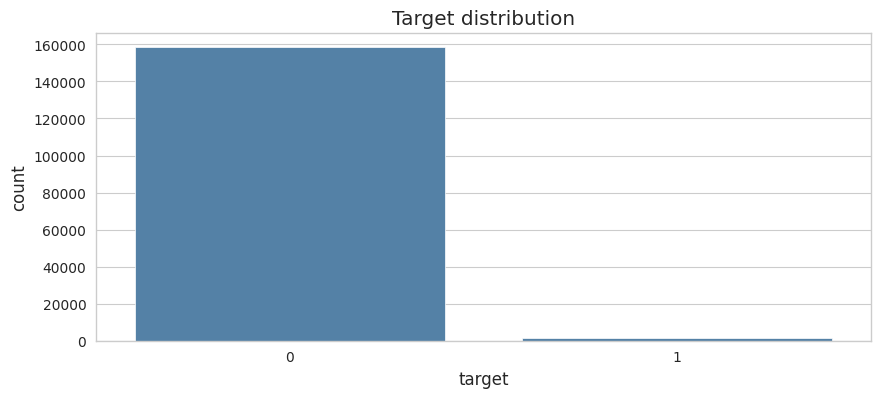

In [ ]:
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.countplot(x=TARGET,data=train_data, color='steelblue').set(title='Target distribution')

In [ ]:
train_data[TARGET].value_counts()

0    158394
1      1575
Name: target, dtype: int64

As we can see, the target distribution is highly imbalanced. We have only 1575 instances for class 1.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159969 entries, 0 to 159968
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  159969 non-null  int64  
 1   webpage1    159969 non-null  int64  
 2   time1       159969 non-null  object 
 3   webpage2    157990 non-null  float64
 4   time2       157990 non-null  object 
 5   webpage3    156066 non-null  float64
 6   time3       156066 non-null  object 
 7   webpage4    154402 non-null  float64
 8   time4       154402 non-null  object 
 9   webpage5    152841 non-null  float64
 10  time5       152841 non-null  object 
 11  webpage6    151324 non-null  float64
 12  time6       151324 non-null  object 
 13  webpage7    149912 non-null  float64
 14  time7       149912 non-null  object 
 15  webpage8    148574 non-null  float64
 16  time8       148574 non-null  object 
 17  webpage9    147160 non-null  float64
 18  time9       147160 non-null  object 
 19  we

* As session_id is unique, we can use it as index

* In one session we have maximum 10 webpages and the corresponding timestamp

* time data is stored as object, so we need to convert it to datetime value

In [ ]:
train_data.set_index('session_id', inplace=True)
test_data.set_index('session_id', inplace=True)

In [ ]:
for col in [f"time{i}" for i in range(1,11)]:
  train_data[col] = pd.to_datetime(train_data[col])
  test_data[col] = pd.to_datetime(test_data[col])

train_data = train_data.sort_values(by=['time1'], ascending=True)

### Time columns

In [ ]:
# Generating some features from time data for EDA
df = pd.DataFrame()
for col in [f"time{i}" for i in range(1,11)]:
        df[col] = pd.to_datetime(train_data[col])

df[TARGET] = train_data[TARGET]

df['session_start'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
df['session_end'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)
df['session_len'] = (df['session_end'] - df['session_start']).dt.seconds #length of the whole session
#year, month, day, weekday, hour and minute data from session start
df['year'] = df['session_start'].dt.year
df['month'] = df['session_start'].dt.month
df['day'] = df['session_start'].dt.day
df['weekday'] = df['session_start'].dt.dayofweek
df['hour'] = df['session_start'].dt.hour
df['minute'] = df['session_start'].dt.minute

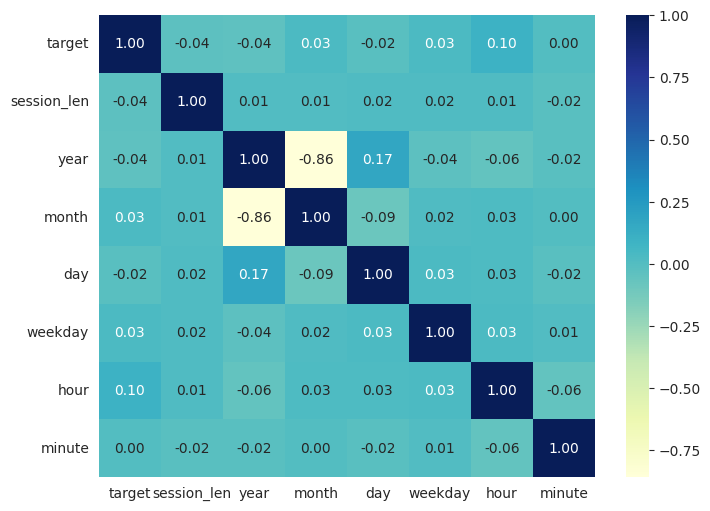

In [ ]:
corr = df.corr('spearman')
plt.figure(figsize = ( 8 , 6 ))
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

We can't see any strong correlation between the time features and the target variable.

In [ ]:
def plotTimefeatures(data, feature):
  plt.figure(figsize=(16, 4))
  sns.set_style("whitegrid")

  plt.subplot(1, 2, 1)
  plt.ylim(0, 100)
  values_perc = data[data[TARGET]==1][feature].value_counts(normalize=True)*100
  ax = sns.barplot(x=values_perc.index, y=values_perc.values, palette="YlGnBu")
  ax.set(ylabel="Percent")
  plt.title("Target=1")

  plt.subplot(1, 2, 2)
  plt.ylim(0, 100)
  values_perc = data[data[TARGET]==0][feature].value_counts(normalize=True)*100
  ax = sns.barplot(x=values_perc.index, y=values_perc.values, palette="YlGnBu")
  ax.set(ylabel="Percent")
  plt.title("Target=0")

  plt.tight_layout()
  plt.suptitle(f"Distribution of {feature}")

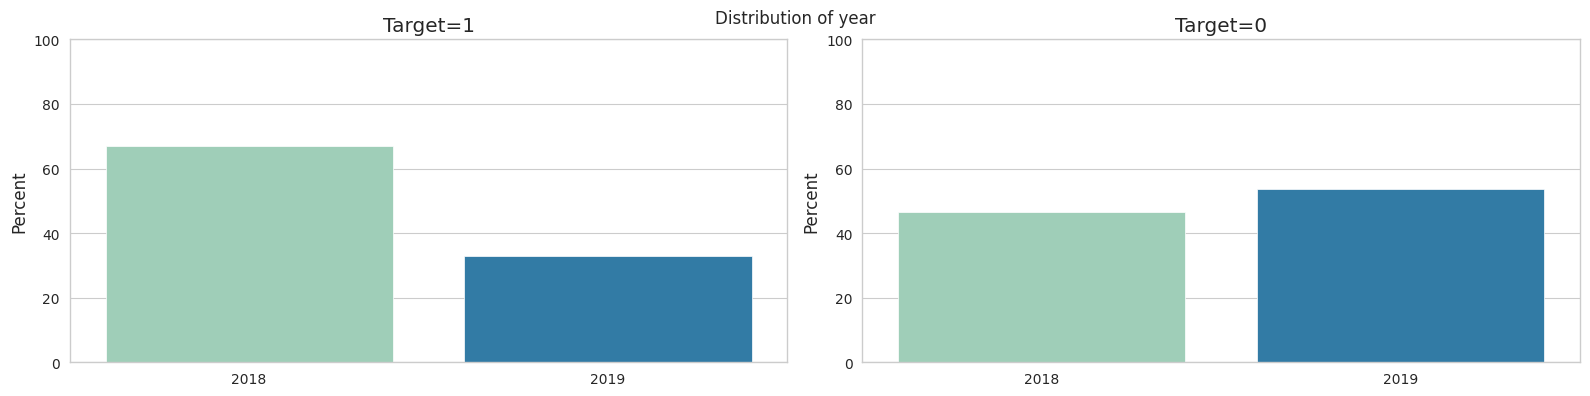

In [ ]:
plotTimefeatures(df, 'year')

The target user was active mostly in 2018, from 2019 we have less sessions initiated by the target user

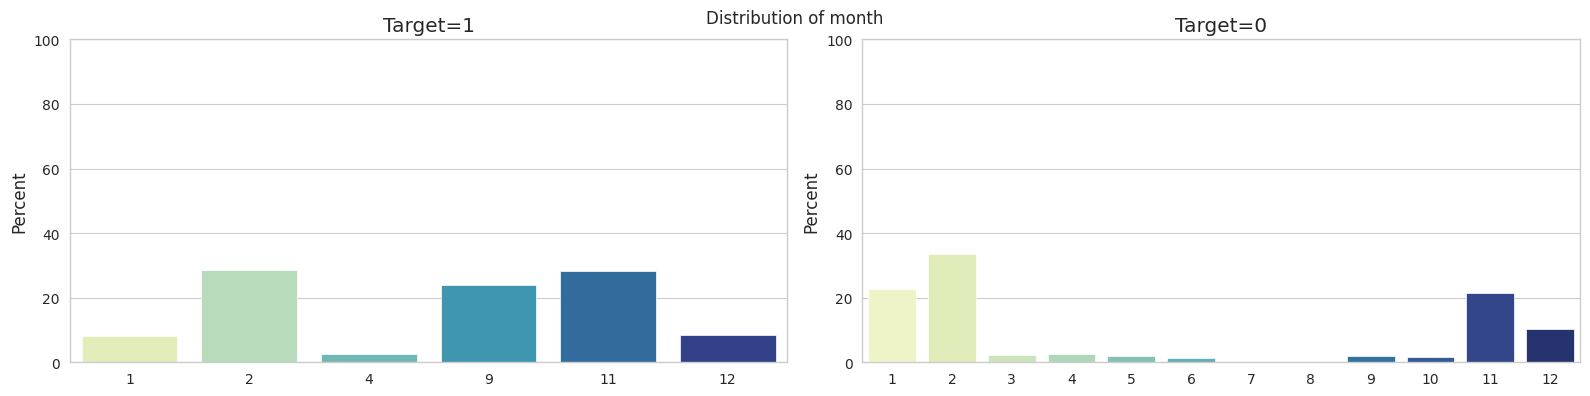

In [ ]:
plotTimefeatures(df, 'month')

As we can see, the target user was not active during the summer ( from May till August)

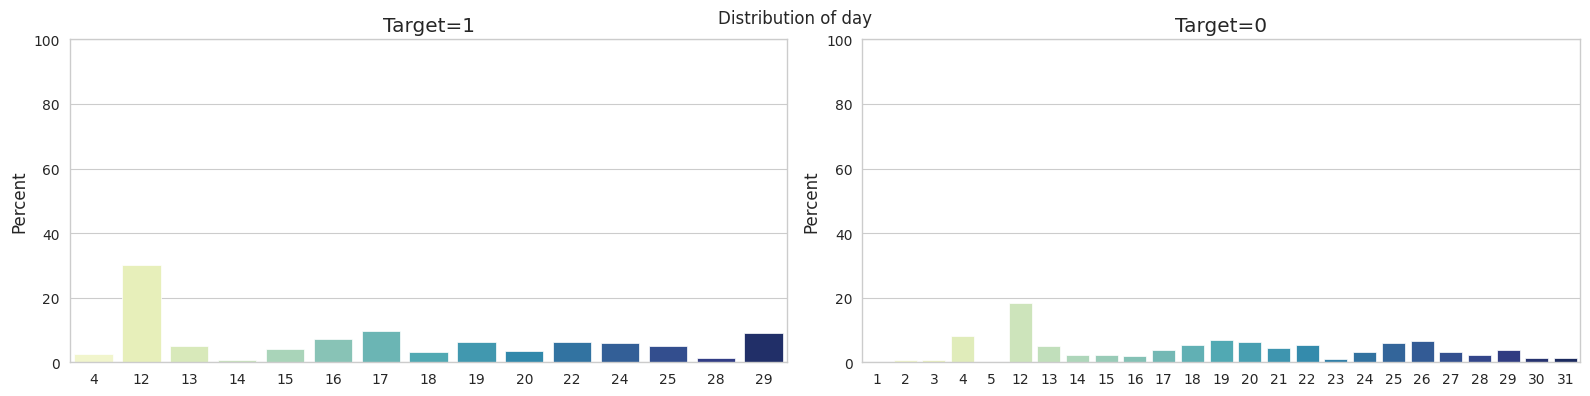

In [ ]:
plotTimefeatures(df, 'day')

The target user is mainly active in the second half of the month, the most sessions occured on the 12th day of the month

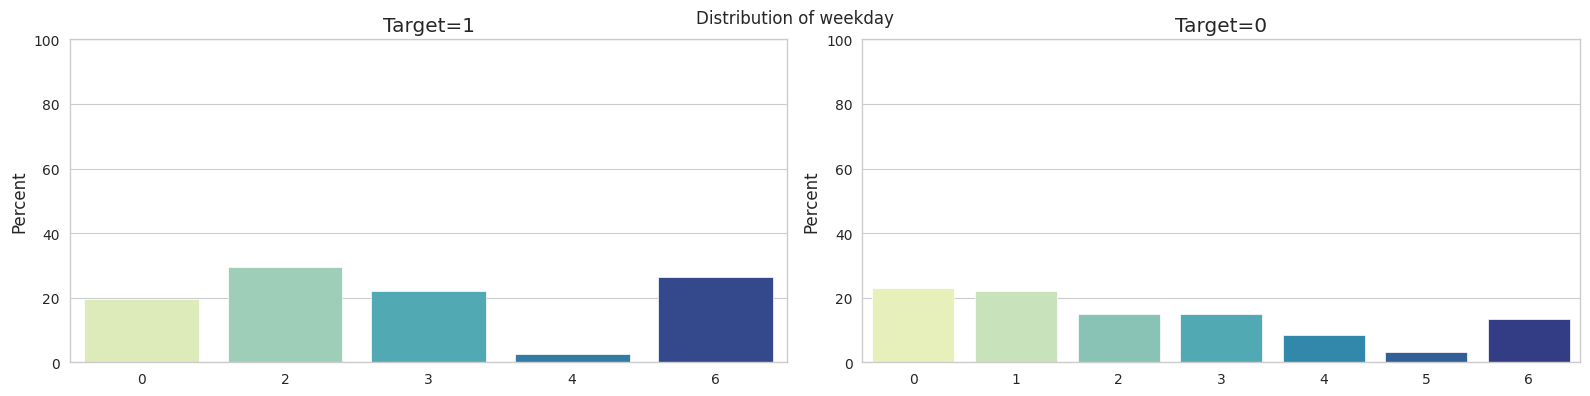

In [ ]:
plotTimefeatures(df, 'weekday')

<Figure size 1600x400 with 0 Axes>

<Axes: >

(0.0, 100.0)

Text(0.5, 1.0, 'Target=1')

<Axes: >

(0.0, 100.0)

Text(0.5, 1.0, 'Target=0')

Text(0.5, 0.98, 'Distribution of session duration')

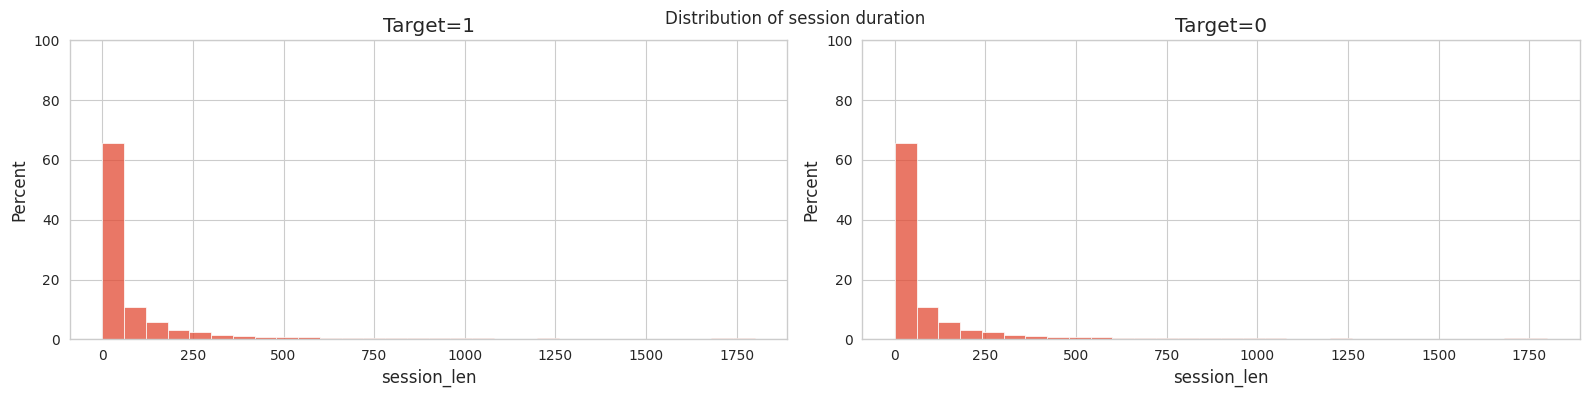

In [ ]:
plt.figure(figsize=(16, 4))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
plt.ylim(0, 100)
ax = sns.histplot(x=df.session_len, data=df[df[TARGET]==1], stat='percent', binwidth=60)
plt.title("Target=1")

plt.subplot(1, 2, 2)
plt.ylim(0, 100)
ax = sns.histplot(x=df.session_len, data=df[df[TARGET]==0], stat='percent', binwidth=60)
plt.title("Target=0")

plt.tight_layout()
plt.suptitle(f"Distribution of session duration")

We can't see any siginificant difference in the distribution of session duration between different target classes

### Webpage columns

In [ ]:
wps = ['webpage%s' % i for i in range(1, 11)]
wp_list = pd.melt(train_data, id_vars =TARGET, value_vars =wps)
wp_list['sitename'] = wp_list['value'].map(id_map['webpage_proc'])
wp_list['domain'] = wp_list['value'].map(id_map['domain_only'])
wp_list.dropna(axis=0, inplace=True)
wp_list.drop(columns=['variable','value'], inplace=True)

In [ ]:
wp_list

,target,sitename,domain
0,0,journaldelarue.files.wordpress.com,wordpress.com
1,0,journaldelarue.files.wordpress.com,wordpress.com
2,0,vendre.autobiz.fr,autobiz.fr
3,0,bfcoi.com,bfcoi.com
4,0,gamehdwall.com,gamehdwall.com
...,...,...,...
1599682,0,oxforddictionaries.com,oxforddictionaries.com
1599683,0,test-qi-officiel.com,test-qi-officiel.com
1599684,0,sr.symcd.com,symcd.com
1599687,0,i1-js-14-3-01-10005-373759141-i.init.cedexis-r...,cedexis-radar.net


In [ ]:
top_sites0 = wp_list[wp_list[TARGET]==0]['sitename'].value_counts().sort_values(ascending=False).head(10)
top_sites0

toquetudiante.files.wordpress.com                         80224
creps-idf.fr                                              58876
test-qi-officiel.com                                      38144
productsandcompany.pmd.redbull.com                        35050
news.bdall.com                                            28663
i1-js-14-3-01-11074-512741507-i.init.cedexis-radar.net    24969
i1-js-14-3-01-11544-97023739-i.init.cedexis-radar.net     23330
i1-js-14-3-01-11074-963595481-i.init.cedexis-radar.net    22015
livedemo00.template-help.com                              20853
i1-js-14-3-01-10077-346208291-i.init.cedexis-radar.net    18047
Name: sitename, dtype: int64

In [ ]:
top_domain0 = wp_list[wp_list[TARGET]==0]['domain'].value_counts().sort_values(ascending=False).head(10)
top_domain0

cedexis-radar.net       184622
wordpress.com            96700
creps-idf.fr             58876
test-qi-officiel.com     38144
redbull.com              35051
bdall.com                28663
template-help.com        20853
wondercity.com           17423
konbini.com              16629
free.fr                  16551
Name: domain, dtype: int64

In [ ]:
top_sites1 = wp_list[wp_list[TARGET]==1]['sitename'].value_counts().sort_values(ascending=False).head(10)
top_sites1

i1-js-14-3-01-11074-963595481-i.init.cedexis-radar.net    1147
sr.symcd.com                                               973
i1-js-14-3-01-10005-373759141-i.init.cedexis-radar.net     915
productsandcompany.pmd.redbull.com                         645
toquetudiante.files.wordpress.com                          627
i1-js-14-3-01-10013-878999337-i.init.cedexis-radar.net     477
images.reply.perkinelmer.com                               377
img.uscri.be                                               304
creps-idf.fr                                               293
test-qi-officiel.com                                       277
Name: sitename, dtype: int64

In [ ]:
top_domain1 = wp_list[wp_list[TARGET]==1]['domain'].value_counts().sort_values(ascending=False).head(10)
top_domain1

cedexis-radar.net       3637
symcd.com                973
wordpress.com            680
redbull.com              645
perkinelmer.com          377
free.fr                  323
uscri.be                 304
creps-idf.fr             293
test-qi-officiel.com     277
disqus.com               274
Name: domain, dtype: int64

If we only ispection the main domains, we can see similarities between the 2 classes, so it is better to use subdomains too for differentiating between the 2 classes.

In [ ]:
nr_of_webpages = pd.DataFrame({'nr_of_webpages':train_data[wps].isnull().sum(axis=1)})
data = pd.concat([train_data[TARGET], nr_of_webpages], axis=1)
data['nr_of_webpages'] = data['nr_of_webpages'].apply(lambda x: 10-x)
data

,target,nr_of_webpages
session_id,,
13694,0,2
34657,0,4
48835,0,10
71986,0,10
92602,0,10
...,...,...
129531,0,3
24530,0,3
139265,0,10


<Figure size 1000x400 with 0 Axes>

[Text(0.5, 1.0, 'Average nr of webpages by target')]

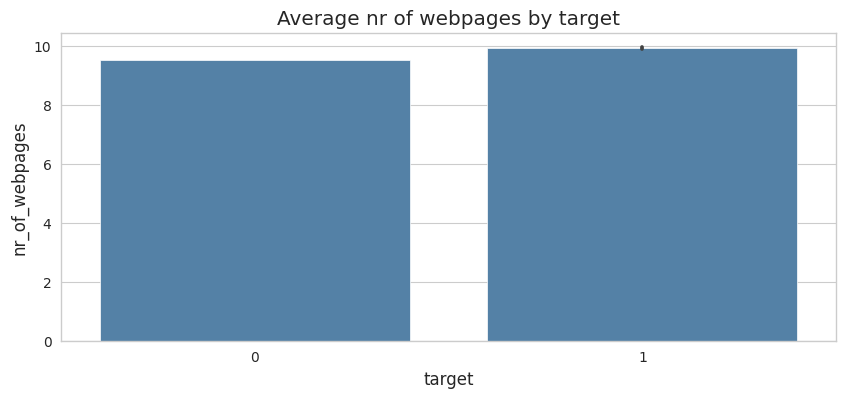

In [ ]:
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.barplot(x=TARGET,y='nr_of_webpages',data=data, color='steelblue',estimator='mean').set(title='Average nr of webpages by target')

We can't see a siginificant differnce between the average number of webpages, opened in 1 session

## Pipelines

In [ ]:
class BaseTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    return None

  def fit(self, X=None, y=None):
    return self

  def transform(self, X=None, y=None):
    return self

In [ ]:
class AttributesAdder(BaseTransformer):
    """
    Add new attributes to training and test set.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
      times = ['time%s' % i for i in range(1, 11)]
      wps = ['webpage%s' % i for i in range(1, 11)]

      month = X['time1'].apply(lambda ts: ts.month).astype('int')
      day = X['time1'].apply(lambda ts: ts.day).astype('int')
      weekday = X['time1'].apply(lambda ts: ts.isoweekday()).astype('int')
      hour = X['time1'].apply(lambda ts: ts.hour).astype('int')
      session_len = (X[times].max(axis=1) - X[times].min(axis=1)).dt.seconds.astype('int')

      number_of_wps = X[wps].isnull().sum(axis=1).apply(lambda x: 10 - x)

      X = np.c_[month.values, day.values, weekday.values, hour.values, session_len.values, number_of_wps.values]

      return X

In [ ]:
class DataPreparator(BaseTransformer):
  """
  Fill NaN with zero values.
  """
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    wps = ['webpage%s' % i for i in range(1, 11)]
    return X[wps].fillna(0).astype('int')

class ListPreparator(BaseTransformer):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X = X.values.tolist()
    # Convert dataframe rows to strings
    return [" ".join([str(site) for site in row]) for row in X]

In [ ]:
vectorizer_pipeline = Pipeline([
  ("preparator", DataPreparator()),
  ("list_preparator", ListPreparator()),
  ("vectorizer", CountVectorizer(ngram_range=(1, 3), max_features=10000))
])

attributes_pipeline = Pipeline([
  ("adder", AttributesAdder())
])

In [ ]:
full_pipeline = FeatureUnion(transformer_list=[
  ('vectorizer_pipeline', vectorizer_pipeline),
  ('attributes_pipeline', attributes_pipeline)
])

In [ ]:
X_train = full_pipeline.fit_transform(train_data)
X_test = full_pipeline.transform(test_data)

In [ ]:
X_train.shape
X_test.shape

(159969, 10006)

(93338, 10006)

In [ ]:
y_train = train_data[TARGET]
y_train.shape

(159969,)

## Models

### Helper functions

In [ ]:
def evaluate_model(classifier, train_set, train_target, skf, metrics=[roc_auc_score]):
  classifier.fit(train_set, train_target)
  results = get_model_metrics(classifier, train_set, train_target, skf, metrics=[roc_auc_score])
  return results

def get_model_metrics(classifier, train_set, train_target, skf, metrics=[roc_auc_score]):
  metrics_result = dict()
  for metric in metrics:
    score = cross_val_score(classifier, train_set, train_target, cv=skf, scoring='roc_auc').mean()
    print("{} for model {} = {:.3f}".format(metric.__name__, classifier.__class__.__name__, score))
    metrics_result[metric.__name__] = score
    metrics_result['classifier'] = classifier.__class__.__name__
    return metrics_result

In [ ]:
def plot_importance(est, colnames, class_nr, top_n=20):
  importance = pd.DataFrame({
      'abs_weight': np.abs(est.feature_importances_[:]),
      'feature': colnames
  })

  imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
  sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h').set(title=f'Class {class_nr}')

In [ ]:
results_by_model = pd.DataFrame()
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

### DecisionTree Classifier

In [ ]:
base_tree = DecisionTreeClassifier(random_state=SEED)
result_dict = evaluate_model(base_tree, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model DecisionTreeClassifier = 0.829


In [ ]:
base_tree_b = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
result_dict = evaluate_model(base_tree, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model DecisionTreeClassifier = 0.829


In [ ]:
def objective(params):
    # Parameters to be optimized
    max_depth = int(params['max_depth'])
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Create DecisionTreeClassifier with specified hyperparameters
    dt_clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    # Fit the model on training data
    dt_clf.fit(X_train, y_train)

    # Calculate accuracy as the objective to be minimized by Hyperopt
    roc_auc = cross_val_score(dt_clf, X_train, y_train, cv=skf, scoring='roc_auc').mean()

    return 1 - roc_auc  # Hyperopt minimizes the objective function

# Define the search space for hyperparameters
space = {
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Use the Tree-structured Parzen Estimator (TPE) algorithm for optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

print("Best Hyperparameters:", best)

100%|██████████| 10/10 [00:34<00:00,  3.42s/trial, best loss: 0.17829098450362102]
Best Hyperparameters: {'max_depth': 8.0, 'min_samples_leaf': 4.0, 'min_samples_split': 9.0}


In [ ]:
best_dt = DecisionTreeClassifier(random_state=42, max_depth=int(best['max_depth']), min_samples_split=int(best['min_samples_split']), min_samples_leaf=int(best['min_samples_leaf']))
result_dict = evaluate_model(best_dt, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model DecisionTreeClassifier = 0.822


The best ROC-AUC score was 82.9 for DecisionTree classifier, even with using class weight function

Using SMOTE oversampling helped significantly improve the scores

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
result_dict = evaluate_model(rf, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model RandomForestClassifier = 0.980


In [ ]:
# Define the objective function for Hyperopt
def objective(params):
    # Parameters to be optimized
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Create RandomForestClassifier with specified hyperparameters
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Fit the model on training data
    rf_clf.fit(X_train, y_train)

    # Calculate accuracy as the objective to be minimized by Hyperopt
    roc_auc = cross_val_score(rf_clf, X_train, y_train, cv=skf, scoring='roc_auc').mean()

    return 1 - roc_auc  # Hyperopt minimizes the objective function

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
}

# Use the Tree-structured Parzen Estimator (TPE) algorithm for optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

print("Best Hyperparameters:", best)

100%|██████████| 10/10 [03:33<00:00, 21.31s/trial, best loss: 0.07272591979536858]
Best Hyperparameters: {'max_depth': 15.0, 'min_samples_leaf': 11.0, 'min_samples_split': 6.0, 'n_estimators': 58.0}


In [ ]:
best_rf = RandomForestClassifier(
        n_estimators=int(best['n_estimators']),
        max_depth=int(best['max_depth']),
        min_samples_split=int(best['min_samples_split']),
        min_samples_leaf=int(best['min_samples_leaf']),
        random_state=42, class_weight='balanced'
    )

result_dict = evaluate_model(best_rf, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model RandomForestClassifier = 0.937


We got better results with RandomForest classifier.

Using balanced class weight, helped to improve the score with 1%

### XGBoost classifier

In [ ]:
xg_clf = XGBClassifier(random_state=SEED)
result_dict = evaluate_model(xg_clf, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model XGBClassifier = 0.996


In [ ]:
def objective(space):
  params = {
    'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
    'learning_rate': '{:.3f}'.format(space['learning_rate']),
    'alpha':  '{:.3f}'.format(space['alpha']),
    'n_estimators': space['n_estimators']
  }

  clf = XGBClassifier(objective='binary:logistic', random_state=SEED, **params)

  score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=skf).mean()

  print("AUC {:.3f} params {}".format(score, params))
  return {'loss':1-score, 'status': STATUS_OK}

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha':  hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
}

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

AUC 0.995 params {'colsample_bytree': '0.348', 'learning_rate': '0.227', 'alpha': '2.523', 'n_estimators': 100}
AUC 0.996 params {'colsample_bytree': '0.585', 'learning_rate': '0.559', 'alpha': '7.021', 'n_estimators': 100}
AUC 0.996 params {'colsample_bytree': '0.514', 'learning_rate': '0.407', 'alpha': '3.696', 'n_estimators': 100}
AUC 0.995 params {'colsample_bytree': '0.418', 'learning_rate': '0.381', 'alpha': '9.294', 'n_estimators': 1000}
AUC 0.997 params {'colsample_bytree': '0.477', 'learning_rate': '0.314', 'alpha': '0.362', 'n_estimators': 1000}
AUC 0.994 params {'colsample_bytree': '0.937', 'learning_rate': '0.162', 'alpha': '9.536', 'n_estimators': 100}
AUC 0.996 params {'colsample_bytree': '0.710', 'learning_rate': '0.735', 'alpha': '1.202', 'n_estimators': 100}
AUC 0.994 params {'colsample_bytree': '0.603', 'learning_rate': '0.717', 'alpha': '9.642', 'n_estimators': 3000}
AUC 0.994 params {'colsample_bytree': '0.319', 'learning_rate': '0.043', 'alpha': '8.900', 'n_estimat

In [ ]:
best_xg = XGBClassifier(objective='binary:logistic', random_state=42,
                            alpha=best['alpha'],
                            colsample_bytree = best['colsample_bytree'],
                            learning_rate = best['learning_rate'],
                            n_estimators=1000
                            )

result_dict = evaluate_model(best_xg, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model XGBClassifier = 0.997


### CATBoost classifier

In [ ]:
cat_clf = CatBoostClassifier(verbose=False, random_state=42)
result_dict = evaluate_model(cat_clf, X_train, y_train, skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model CatBoostClassifier = 0.990


### LightGBM Classifier

In [ ]:
lgb_clf_ib = LGBMClassifier(n_estimators=1000, random_state=42, is_unbalance=True)
result_dict = evaluate_model(lgb_clf, X_train.astype('float32'), y_train.astype('float32'), skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

[LightGBM] [Info] Number of positive: 1575, number of negative: 158394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 20.280874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33727
[LightGBM] [Info] Number of data points in the train set: 159969, number of used features: 9336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009846 -> initscore=-4.610830
[LightGBM] [Info] Start training from score -4.610830
[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 14.979315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31569
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 9081
[LightGB

In [ ]:
lgb_clf = LGBMClassifier(n_estimators=1000, random_state=42, is_unbalance=True)
result_dict = evaluate_model(lgb_clf, X_train.astype('float32'), y_train.astype('float32'), skf)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

[LightGBM] [Info] Number of positive: 1575, number of negative: 158394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 18.704832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33727
[LightGBM] [Info] Number of data points in the train set: 159969, number of used features: 9336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009846 -> initscore=-4.610830
[LightGBM] [Info] Start training from score -4.610830
[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 14.914808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31569
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 9081
[LightGB

### Results

In [ ]:
results_by_model.sort_values(by='roc_auc_score', ascending=False)

,roc_auc_score,classifier
3,0.996602,XGBClassifier
5,0.996095,LGBMClassifier
2,0.995573,XGBClassifier
4,0.990168,CatBoostClassifier
0,0.829004,DecisionTreeClassifier
1,0.821709,DecisionTreeClassifier


We got the best results with XGB Classifier.

The results are similar on the predictions of test data.

(ROC AUC on test data: 0.95154)

### Generating output file

In [ ]:
output = best_xg.predict_proba(X_test)

In [ ]:
pd_output = pd.DataFrame({'session_id':test_data.index, 'target':output[:,1]})

In [ ]:
pd_output.to_csv('/content/gdrive/MyDrive/Data_Science_mentoring/07_classification_3/submission.csv', header=True, index=False)

In [ ]:
!kaggle competitions submit -c hbdsc-classification-3-challenge -f submission.csv -m "Message"